# 🧪 Knowledge Distillation: gpt5_mini → EfficientNetB3

使用 gpt5_mini 作为教师模型，通过知识蒸馏训练 EfficientNetB3 学生模型

## 配置 ✨ v11.2 - 知识蒸馏（含T²梯度补偿）
- **教师模型**: gpt5_mini (软标签，准确率93.67%)
- **学生模型**: EfficientNetB3
- **损失函数**: α=0.9 (KL×T²) + β=0.1 (CE) - 🎯 更偏重教师软标签以强化知识迁移
- **训练策略**: 特征提取20轮 + 微调40轮 (总60轮)
- **批量大小**: 32 - 提升训练效率
- **学习率**: 初始1e-4, 微调3e-5 (与baseline v9一致)
- **EarlyStopping**: patience=15 - 🔧 给模型更多学习时间
- **Temperature**: 2.0 - 🔧 软化logits，使知识转移更平滑
- **T²补偿**: ✅ 已启用 - 根据Hinton论文，KL损失乘以T²=4.0平衡温度对梯度的影响
- **Label Smoothing**: 0.0 - 🔧 v11.2: 移除平滑，专注学习教师软标签
- **数据增强**: 轻度增强 (rotation=20, shift=0.15, zoom=0.18)
- **正则化**: L2=1e-4, Dropout=0.5
- **解冻层数**: 70层

### 🔬 v11.2 核心改进（T²梯度补偿）
| 参数 | v11.1 | v11.2 | 原因 |
|------|-------|-------|------|
| T²补偿 | ❌ 未明确 | ✅ KL × T² | ⭐⭐⭐ 根据Hinton论文，温度T软化logits时梯度被1/T²缩放，需T²补偿 |
| Temperature | 3.0 | 2.0 | 降低温度，T=2.0时T²=4.0 |
| KL/CE权重 | 0.5/0.5 | 0.9/0.1 | 训练改为偏重KL(教师知识)，提高软标签的影响 |
| Label Smoothing | 0.02 | 0.0 | 移除平滑，让模型完全信任教师软标签 |

**🎯 关键说明**: 
- **T²补偿原理**: 使用温度T软化logits时，softmax的梯度会被缩放1/T²，因此KL损失需要乘以T²来平衡
- **公式**: `Total Loss = α × T² × KL(soft, pred) + β × CE(hard, pred)`
- **效果**: 确保软标签和硬标签对训练的贡献在相同数量级，避免温度参数影响训练平衡

基于 LLM-Emotion（CNNonly）/notebooks/01_train_dog_emotion.ipynb 改造

## 1. 导入和环境设置

In [1]:
# 标准库导入
import os, json, random, math, warnings, pathlib, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_auc_score
)

# TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.models import Model
import cv2

# 添加src路径
sys.path.append('../src')
from distillation_utils import (
    DistillationDataGenerator,
    create_distillation_loss,
    create_distillation_metrics,
    DistillationMonitor,
    validate_data_alignment
)

# 🆕 导入 Mixup 工具（用于数据增强，提高蒸馏效果）
try:
    # 尝试从上层目录导入 mixup_utils
    mixup_utils_found = False
    search_dirs = ['..', '../../03_EfficientNETB3+GPT', '../..']
    for d in search_dirs:
        search_dir = pathlib.Path(d).resolve()
        for candidate in [search_dir, search_dir / '03_EfficientNETB3+GPT']:
            if (candidate / 'mixup_utils.py').exists():
                sys.path.insert(0, str(candidate))
                from mixup_utils import mixup_generator
                mixup_utils_found = True
                print(f'✅ Mixup utilities loaded from: {candidate}')
                break
        if mixup_utils_found:
            break
    if not mixup_utils_found:
        print('⚠️ mixup_utils.py not found - Mixup功能将被禁用')
except Exception as e:
    print(f'⚠️ Failed to import mixup_utils: {e}')
    mixup_utils_found = False

warnings.filterwarnings('ignore')
print('✅ TF version:', tf.__version__)
print('✅ GPUs:', tf.config.list_physical_devices('GPU'))
print('✅ Distillation utilities loaded')

✅ Mixup utilities loaded from: E:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\03_EfficientNETB3+GPT
✅ TF version: 2.10.0
✅ GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Distillation utilities loaded


## 2. GPU配置（可选：CPU训练）

In [2]:
# Runtime guard: Python/TF versions and optional GPU toggle
print('Python:', sys.version)
print('Executable:', sys.executable)

# Force CPU-only for Windows (no Metal/CUDA)
USE_GPU = True
if not USE_GPU:
    try:
        tf.config.set_visible_devices([], 'GPU')
        print('✅ GPU disabled: using CPU only')
    except Exception as e:
        print('Failed to disable GPU:', e)

print('TF:', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Executable: d:\anaconda3\envs\tf210_gpu\python.exe
TF: 2.10.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. 配置和随机种子

In [3]:
# Config & seeds
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Windows 路径自动检测
def get_windows_base_dir():
    """自动检测 Windows 上的数据目录"""
    candidates = [
        r'e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\LLM-Emotion（EfficientNetB3only）\data\Dog Emotion',
        r'E:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\LLM-Emotion（EfficientNetB3only）\data\Dog Emotion',
    ]
    for p in candidates:
        if os.path.isdir(p):
            return p
    # 如果都不存在，返回第一个候选路径（会在后续检查中报错）
    return candidates[0]

def get_windows_soft_labels_path():
    """自动检测 Windows 上的软标签文件路径"""
    candidates = [
        r'e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\data\soft_labels.csv',
        r'E:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\data\soft_labels.csv',
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return candidates[0]

CONFIG = {
    # Windows 数据目录
    'base_dir': get_windows_base_dir(),
    'image_size': (300, 300),
    'batch_size': 8,  # synchronized with baseline
    'num_classes': 4,
    'epochs_initial': 15,  # synchronized with baseline (feature extraction)
    'epochs_finetune': 35,  # synchronized with baseline (fine-tune)
    'learning_rate_initial': 1e-4,  # synchronized with baseline
    'learning_rate_finetune': 3e-5,  # synchronized with baseline
    'validation_split': 0.2,
    'random_seed': 42,
    'valid_emotions': ['angry', 'happy', 'relaxed', 'sad'],
    'label_smoothing': 0.0,  # 🔧 v11.2: 0.02→0.0 移除平滑，专注学习教师软标签

    # 🆕 知识蒸馏配置
    'distillation': {
        'alpha': 1,  # default; change as needed
        'beta': 0,
        'temperature': 2.0,  # 温度参数T=2.0，KL损失会自动乘以T²=4.0进行梯度补偿
        # Windows 软标签文件路径
        'soft_labels_path': get_windows_soft_labels_path()
    },

    # 🆕 Mixup 数据增强配置（提高蒸馏效果，减少过拟合）
    'mixup': {
        'enabled': False,  # 是否启用 Mixup
        'alpha': 0.2      # Mixup强度
    },

    # 🆕 正则化配置（与baseline对齐）
    'regularization': {
        'dropout_rate': 0.5,  # Dropout比率，增强泛化 (baseline)
        'l2_penalty': 1e-4    # L2正则化系数 (baseline)
    }
}

set_random_seeds(CONFIG['random_seed'])
print(json.dumps(CONFIG, indent=2, ensure_ascii=False))

# 🆕 自动生成tag（基于α和β参数）
alpha = CONFIG['distillation']['alpha']
beta = CONFIG['distillation']['beta']
TAG = f"{alpha}+{beta}"
print(f"\n🏷️  自动生成TAG: {TAG}")
print(f"   (基于 α={alpha}, β={beta})")
print(f"   所有输出文件将使用此标签")

# Project root & output dirs
PROJECT_ROOT = os.path.abspath('..')
OUT_DIR = os.path.join(PROJECT_ROOT, 'results')
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')
REPORT_DIR = os.path.join(PROJECT_ROOT, 'reports')
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

print(f"\n📂 Output directory: {OUT_DIR}")
print(f"📂 Model directory: {MODEL_DIR}")
print(f"📂 Report directory: {REPORT_DIR}")

{
  "base_dir": "e:\\BaiduNetdiskDownload\\LLMemotion\\LLMemotion\\LLMemotion\\LLM-Emotion（EfficientNetB3only）\\data\\Dog Emotion",
  "image_size": [
    300,
    300
  ],
  "batch_size": 8,
  "num_classes": 4,
  "epochs_initial": 15,
  "epochs_finetune": 35,
  "learning_rate_initial": 0.0001,
  "learning_rate_finetune": 3e-05,
  "validation_split": 0.2,
  "random_seed": 42,
  "valid_emotions": [
    "angry",
    "happy",
    "relaxed",
    "sad"
  ],
  "label_smoothing": 0.0,
  "distillation": {
    "alpha": 1,
    "beta": 0,
    "temperature": 2.0,
    "soft_labels_path": "e:\\BaiduNetdiskDownload\\LLMemotion\\LLMemotion\\LLMemotion\\（1.1）EfficientNETB3+GPT\\data\\soft_labels.csv"
  },
  "mixup": {
    "enabled": false,
    "alpha": 0.2
  },
  "regularization": {
    "dropout_rate": 0.5,
    "l2_penalty": 0.0001
  }
}

🏷️  自动生成TAG: 1+0
   (基于 α=1, β=0)
   所有输出文件将使用此标签

📂 Output directory: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results
📂 Model

## 4. 数据检查

Class counts: {'angry': 1000, 'happy': 1000, 'relaxed': 1000, 'sad': 1000}
Total images: 4000


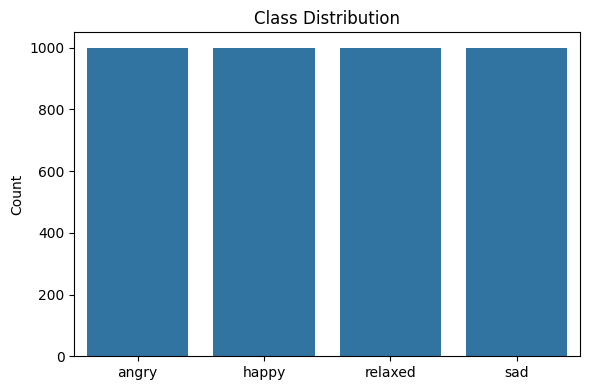

In [4]:
# Data sanity check
base_dir = CONFIG['base_dir']
assert os.path.isdir(base_dir), f'Base dir not found: {base_dir}'

classes = CONFIG['valid_emotions']
for c in classes:
    d = os.path.join(base_dir, c)
    assert os.path.isdir(d), f'Missing class folder: {d}'

def count_images_by_class(base_dir, classes):
    counts = {}
    for c in classes:
        cdir = os.path.join(base_dir, c)
        n = sum(1 for f in os.listdir(cdir) 
                if f.lower().endswith(('.jpg','.jpeg','.png','.bmp')))
        counts[c] = n
    return counts

counts = count_images_by_class(base_dir, classes)
print('Class counts:', counts)
print(f'Total images: {sum(counts.values())}')

plt.figure(figsize=(6,4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title('Class Distribution')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 5. 🆕 加载软标签

In [5]:
# 加载 gpt5_mini 的软标签
soft_labels_path = CONFIG['distillation']['soft_labels_path']
assert os.path.exists(soft_labels_path), (
    f"❌ Soft labels not found: {soft_labels_path}\n"
    f"Please run 01_prepare_soft_labels.ipynb first!"
)

soft_labels_df = pd.read_csv(soft_labels_path)
print(f"✅ Loaded soft labels: {len(soft_labels_df)} samples")
print(f"\nColumns: {list(soft_labels_df.columns)}")
print(f"\nFirst 3 samples:")
display(soft_labels_df.head(3))

✅ Loaded soft labels: 4000 samples

Columns: ['filename', 'angry_prob', 'happy_prob', 'relaxed_prob', 'sad_prob']

First 3 samples:


,filename,angry_prob,happy_prob,relaxed_prob,sad_prob
0,20954578232_4ab11f2f30_b.jpg,0.05,0.15,0.7,0.1
1,2RjDxA7ONK70VKnqz74UtaJ4iAzwL5427.jpg,0.70,0.10,0.1,0.1
2,Md5JkFuXpbftuCAxmpqIeTpqNNwbSB423.jpg,0.70,0.00,0.2,0.1


## 6. 创建数据生成器

In [6]:
# Generators (with augmentations for training)
def create_emotion_only_generators(base_dir, valid_emotions, config):
    """Create train/val generators but only include emotion folders that actually contain image files.
    This ignores non-class folders like `metadata` and avoids including empty dirs.
    """
    import glob
    import shutil
    from pathlib import Path
    
    def dir_has_images(dpath):
        try:
            return any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')) for f in os.listdir(dpath))
        except Exception:
            return False

    existing_emotions = []
    ignored = []
    for emotion in valid_emotions:
        emotion_path = os.path.join(base_dir, emotion)
        if os.path.isdir(emotion_path) and dir_has_images(emotion_path):
            existing_emotions.append(emotion)
            print(f'Found emotion folder with images: {emotion}')
        else:
            ignored.append(emotion)
            print(f'Ignoring/missing emotion folder or no images: {emotion}')
    if ignored:
        print('⚠️ The following expected classes were missing or empty and will be ignored:', ignored)

    # 🔧 v12: 手动打乱数据集，创建train/val子目录
    # 解决validation_split按文件名顺序分割的问题
    train_dir = os.path.join(base_dir, '_shuffled_train')
    val_dir = os.path.join(base_dir, '_shuffled_val')
    
    # 如果已存在打乱的目录，直接使用
    if os.path.exists(train_dir) and os.path.exists(val_dir):
        print(f'✅ 使用已存在的打乱数据集: {train_dir}, {val_dir}')
    else:
        print(f'🔄 创建打乱的train/val分割...')
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        
        np.random.seed(config['random_seed'])
        val_split = config['validation_split']
        
        for emotion in existing_emotions:
            # 获取所有图片文件
            emotion_path = os.path.join(base_dir, emotion)
            all_files = glob.glob(os.path.join(emotion_path, '*.*'))
            all_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            
            # 随机打乱
            np.random.shuffle(all_files)
            
            # 分割
            val_count = int(len(all_files) * val_split)
            val_files = all_files[:val_count]
            train_files = all_files[val_count:]
            
            # 创建目标目录
            train_emotion_dir = os.path.join(train_dir, emotion)
            val_emotion_dir = os.path.join(val_dir, emotion)
            os.makedirs(train_emotion_dir, exist_ok=True)
            os.makedirs(val_emotion_dir, exist_ok=True)
            
            # 复制文件（使用符号链接节省空间，Windows需要管理员权限，失败则复制）
            for src in train_files:
                dst = os.path.join(train_emotion_dir, os.path.basename(src))
                try:
                    os.symlink(src, dst)
                except:
                    shutil.copy2(src, dst)
            
            for src in val_files:
                dst = os.path.join(val_emotion_dir, os.path.basename(src))
                try:
                    os.symlink(src, dst)
                except:
                    shutil.copy2(src, dst)
            
            print(f'  {emotion}: {len(train_files)} train, {len(val_files)} val')
        
        print(f'✅ 数据集打乱完成')

    # 🔧 v18: 与ResNet50/baseline对齐的强数据增强
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,           # 🔧 v18: 20→30 增强旋转
        width_shift_range=0.25,      # 🔧 v18: 0.15→0.25 增强位移
        height_shift_range=0.25,     # 🔧 v18: 0.15→0.25 增强位移
        shear_range=0.15,            # 🔧 v18: 0.08→0.15 增强剪切
        zoom_range=0.2,              # 🔧 v18: 0.18→0.2 增强缩放
        horizontal_flip=True,
        brightness_range=[0.8, 1.2], # 🔧 v18: [0.85,1.15]→[0.8,1.2] 增强亮度
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=config['image_size'], batch_size=config['batch_size'],
        class_mode='categorical', shuffle=True,
        seed=config['random_seed'], classes=existing_emotions,
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=config['image_size'], batch_size=config['batch_size'],
        class_mode='categorical', shuffle=False,
        seed=config['random_seed'], classes=existing_emotions,
    )
    
    # 🚀 优化数据加载性能，减少 DRAM 瓶颈
    print("\n🚀 启用多线程数据加载优化...")
    # 注意：这些是 DirectoryIterator 的内部属性，需谨慎使用
    # 增加工作线程数，让数据预加载更快
    import multiprocessing
    num_workers = min(multiprocessing.cpu_count(), 8)  # 最多使用8个worker
    
    # 注意：Keras的ImageDataGenerator不直接支持workers参数
    # 需要在model.fit()中设置，这里仅记录配置
    print(f"   将在 model.fit() 中使用 workers={num_workers}, use_multiprocessing=True")
    print(f"   这将显著提升数据加载速度，减少GPU等待时间")

    print('\nTraining classes:', train_gen.class_indices)
    print('Validation classes:', val_gen.class_indices)
    print(f'\n📊 数据分割: 训练集 {train_gen.n}, 验证集 {val_gen.n}')
    return train_gen, val_gen, existing_emotions

train_gen, val_gen, existing_emotions = create_emotion_only_generators(
    CONFIG['base_dir'], CONFIG['valid_emotions'], CONFIG
)
CONFIG['num_classes'] = len(existing_emotions)
print(f"\n✅ Updated num_classes: {CONFIG['num_classes']}")

Found emotion folder with images: angry
Found emotion folder with images: happy
Found emotion folder with images: relaxed
Found emotion folder with images: sad
✅ 使用已存在的打乱数据集: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\LLM-Emotion（EfficientNetB3only）\data\Dog Emotion\_shuffled_train, e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\LLM-Emotion（EfficientNetB3only）\data\Dog Emotion\_shuffled_val
Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.

🚀 启用多线程数据加载优化...
   将在 model.fit() 中使用 workers=8, use_multiprocessing=True
   这将显著提升数据加载速度，减少GPU等待时间

Training classes: {'angry': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}
Validation classes: {'angry': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}

📊 数据分割: 训练集 3200, 验证集 800

✅ Updated num_classes: 4


## 7. 🆕 验证数据对齐

In [7]:
# 验证训练集和GPT-4o-mini软标签的对齐情况
is_aligned = validate_data_alignment(train_gen, soft_labels_df)

if not is_aligned:
    print("\n⚠️ Warning: Data alignment is not perfect, but training can continue.")
    print("   Missing samples will use hard labels instead of soft labels.")


🔍 Validating Data Alignment

📊 Alignment Statistics:
   Training samples:          3200
   GPT-4o-mini predictions:   3999
   Aligned samples:           3200
   Missing predictions:       0
   Extra predictions:         799

✅ Coverage: 100.00%
✅ Good coverage! Ready for distillation training.



## 8. 🆕 创建蒸馏数据生成器

In [8]:
# 包装训练生成器为蒸馏生成器
distill_train_gen = DistillationDataGenerator(
    base_generator=train_gen,
    soft_labels_df=soft_labels_df,
    class_names=CONFIG['valid_emotions']
)

print(f"\n✅ Distillation generator ready!")
print(f"   Train batches per epoch: {len(distill_train_gen)}")

# 将验证生成器也包装为蒸馏生成器，确保训练/验证阶段的 y 形状一致（hard + soft）
distill_val_gen = DistillationDataGenerator(
    base_generator=val_gen,
    soft_labels_df=soft_labels_df,
    class_names=CONFIG['valid_emotions']
)
print(f"   Validation batches (distilled): {len(distill_val_gen)}")

# 简单检查首个 batch 的 y 形状 (hard + soft)，避免在训练时出现形状不匹配问题
try:
    _, y_train0 = distill_train_gen[0]
    _, y_val0 = distill_val_gen[0]
    print(f"   distill_train_gen[0] y shape: {getattr(y_train0, 'shape', None)}")
    print(f"   distill_val_gen[0]   y shape: {getattr(y_val0, 'shape', None)}")
except Exception as e:
    print('   Could not read batch shapes:', e)

# 评估时仍使用原始 val_gen（仅硬标签），以保持 comprehensive_evaluation 的行为不变
print(f"\n✅ Validation generator: {len(val_gen)} batches (kept for final evaluation)")

# 🆕 保存步数信息（Mixup 包装前）
steps_per_epoch = len(distill_train_gen)
validation_steps = len(distill_val_gen)

# 🆕 Mixup 包装（如果启用）
if CONFIG['mixup']['enabled'] and mixup_utils_found:
    print(f"\n🔄 Applying Mixup augmentation (alpha={CONFIG['mixup']['alpha']})...")
    # 将训练生成器包装为 Mixup 生成器
    # 注意：Mixup会同时混合图像和标签（包括硬标签和软标签）
    distill_train_gen = mixup_generator(distill_train_gen, alpha=CONFIG['mixup']['alpha'])
    print("✅ Mixup enabled for training generator")
    print("   Benefits: 减少过拟合, 提高泛化能力, 与软标签蒸馏协同工作")
    print(f"   Steps per epoch: {steps_per_epoch} (manually specified for generator)")
else:
    if CONFIG['mixup']['enabled'] and not mixup_utils_found:
        print("⚠️ Mixup enabled in config but mixup_utils not found - training without Mixup")
    else:
        print("ℹ️ Mixup disabled in config")

✅ DistillationDataGenerator initialized:
   Total samples: 3200
   Batch size: 8
   Soft labels loaded: 3999
   Coverage: 100.00%

✅ Distillation generator ready!
   Train batches per epoch: 400
✅ DistillationDataGenerator initialized:
   Total samples: 800
   Batch size: 8
   Soft labels loaded: 3999
   Coverage: 100.00%
   Validation batches (distilled): 100
   distill_train_gen[0] y shape: (8, 8)
   distill_val_gen[0]   y shape: (8, 8)

✅ Validation generator: 100 batches (kept for final evaluation)
ℹ️ Mixup disabled in config


## 9. 构建模型（EfficientNetB3 + 多尺度特征）

In [9]:
# Model: EfficientNetB3 + multi-scale head
# 修复 Keras 3 + TF 2.19 权重加载兼容性问题
from typing import Optional
from tensorflow.keras.utils import get_file
import os as _os

def find_layer_contains(model, key: str) -> Optional[str]:
    names = [l.name for l in model.layers]
    for n in names:
        if key in n:
            return n
    return None

def doggo_model(config):
    # 先不加载权重，避免 Keras 3 的形状不匹配问题
    base_model = EfficientNetB3(
        include_top=False, weights='imagenet',
        input_shape=(*config['image_size'], 3)
    )
    
    # 手动下载预训练权重（不校验hash，避免缓存损坏问题）
    try:
        weights_path = get_file(
            'efficientnetb3_notop.h5',
            'https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5',
            cache_subdir='models'
        )
        # 加载权重，使用 by_name=True 配合 skip_mismatch=True
        base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print("✅ EfficientNetB3 预训练权重加载成功 (by_name=True, skip_mismatch=True)")
    except Exception as e:
        print(f"⚠️ 权重加载警告: {e}")
        print("   继续使用随机初始化权重...")
    
    base_model.trainable = False
    inputs = base_model.input

    # Robust layer name search
    low_key = 'block2a_expand_activation'
    mid_key = 'block4a_expand_activation'
    low_name = find_layer_contains(base_model, low_key) or find_layer_contains(base_model, 'block2a')
    mid_name = find_layer_contains(base_model, mid_key) or find_layer_contains(base_model, 'block4a')
    
    if low_name is None or mid_name is None:
        print('Available layers (head):', [l.name for l in base_model.layers[-30:]])
        raise ValueError('Could not find expected EfnB3 blocks')

    low_level = base_model.get_layer(low_name).output
    mid_level = base_model.get_layer(mid_name).output
    high_level = base_model.output

    low_features = layers.GlobalAveragePooling2D(name='low_gap')(low_level)
    mid_features = layers.GlobalAveragePooling2D(name='mid_gap')(mid_level)
    high_features = layers.GlobalAveragePooling2D(name='high_gap')(high_level)
    combined = layers.Concatenate(name='feature_concat')([low_features, mid_features, high_features])

    # Classification head - 🔧 v18: 使用config中的正则化参数（与ResNet50/baseline对齐）
    dropout = config.get('regularization', {}).get('dropout_rate', 0.5)
    l2_reg = config.get('regularization', {}).get('l2_penalty', 3e-4)
    
    x = layers.Dense(1024, activation='swish', name='dense_1024',
                    kernel_regularizer=regularizers.l2(l2_reg))(combined)  # 🔧 v18: 使用config值1e-4
    x = layers.BatchNormalization(name='bn_1024')(x)
    x = layers.Dropout(dropout, name='dropout_1')(x)  # 🔧 v18: 使用config值0.5
    x = layers.Dense(512, activation='swish', name='dense_512',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)  # 🔧 v18: 使用config值1e-4
    x = layers.BatchNormalization(name='bn_512')(x)
    x = layers.Dropout(dropout * 0.3, name='dropout_2')(x)  # 第二层dropout略低
    outputs = layers.Dense(config['num_classes'], activation='softmax', name='predictions')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='DogEmotionClassifier_Distilled')
    return model

model = doggo_model(CONFIG)
print("\n✅ Model built successfully!")
model.summary()

✅ EfficientNetB3 预训练权重加载成功 (by_name=True, skip_mismatch=True)

✅ Model built successfully!
Model: "DogEmotionClassifier_Distilled"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                             

## 10. 🆕 配置蒸馏损失和指标

In [10]:
# 创建蒸馏损失函数
distill_loss = create_distillation_loss(
    alpha=CONFIG['distillation']['alpha'],
    beta=CONFIG['distillation']['beta'],
    temperature=CONFIG['distillation']['temperature']
)

# 创建监控指标
distill_metrics = create_distillation_metrics()

print(f"✅ Distillation loss configured:")
print(f"   α (KL weight): {distill_loss.alpha}")
print(f"   β (CE weight): {distill_loss.beta}")
print(f"   Temperature: {distill_loss.temperature}")
print(f"   T² (gradient compensation): {distill_loss.temperature ** 2}")
print(f"\n   Loss = {distill_loss.alpha} × {distill_loss.temperature ** 2:.1f} × KL + {distill_loss.beta} × CE")
print(f"   Loss = {distill_loss.alpha} × T² × KL + {distill_loss.beta} × CE")


✅ Distillation loss configured:
   α (KL weight): 1
   β (CE weight): 0
   Temperature: 2.0
   T² (gradient compensation): 4.0

   Loss = 1 × 4.0 × KL + 0 × CE
   Loss = 1 × T² × KL + 0 × CE


## 11. Optimizer & Callbacks

In [11]:
# Optimizer & Callbacks
# 🔧 使用传统 Adam 优化器，避免 XLA JIT 编译问题
from tensorflow.keras.optimizers import Adam

# 模型保存路径
best_weights_path = os.path.join(MODEL_DIR, 'best_distilled_efnb3_weights.h5')
REPORT_DIR = os.path.join(PROJECT_ROOT, 'reports')
training_log_path = os.path.join(REPORT_DIR, 'distillation_training_log.csv')
os.makedirs(REPORT_DIR, exist_ok=True)

# Callbacks
def doggo_callbacks():
    """
    🔧 v11.1: 优化callbacks以提升蒸馏效果
    - 增加patience让模型有更多时间学习教师知识
    """
    return [
        callbacks.EarlyStopping(
            monitor='val_hard_acc', patience=15,  # 🔧 v11.1: 12→15 给模型更多学习时间
            restore_best_weights=True, verbose=1, mode='max'
        ),
        callbacks.ModelCheckpoint(
            filepath=best_weights_path,
            monitor='val_hard_acc', mode='max',
            save_best_only=True, verbose=1,
            save_weights_only=True  # 🔧 关键修复：只保存权重
        ),
        callbacks.CSVLogger(training_log_path, append=False),
        # 🆕 蒸馏监控
        DistillationMonitor(
            alpha=CONFIG['distillation']['alpha'],
            beta=CONFIG['distillation']['beta']
        )
    ]

cb_list = doggo_callbacks()
print("✅ Callbacks configured (fixed learning rate)")
print(f"   - EarlyStopping patience=15")
print(f"   - ReduceLROnPlateau removed (使用固定学习率)")
print(f"✅ 模型权重将自动保存到: {best_weights_path}")
print(f"✅ 训练日志将保存到: {training_log_path}")

✅ Callbacks configured (fixed learning rate)
   - EarlyStopping patience=15
   - ReduceLROnPlateau removed (使用固定学习率)
✅ 模型权重将自动保存到: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\best_distilled_efnb3_weights.h5
✅ 训练日志将保存到: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\reports\distillation_training_log.csv


## 12. 🆕 编译模型（使用蒸馏损失）

In [12]:
# 🔧 使用传统 Adam 优化器编译模型
model.compile(
    optimizer=Adam(learning_rate=CONFIG['learning_rate_initial']),
    loss=distill_loss,        # 🔄 使用蒸馏损失
    metrics=distill_metrics   # 🔄 使用蒸馏指标
)

print("✅ Model compiled with distillation loss (using Adam optimizer)!")

✅ Model compiled with distillation loss (using Adam optimizer)!


## 13. Smoke Test

In [13]:
# Smoke test: one forward pass
# 注意: 如果启用了 Mixup，distill_train_gen 是 generator，需要用 next(iter())
# 如果未启用 Mixup，它是 Keras Sequence，可以用索引访问
try:
    # 尝试索引访问（未启用 Mixup 的情况）
    xb, yb = distill_train_gen[0]
except TypeError:
    # 如果是 generator（启用了 Mixup），使用迭代器
    print('Note: Using iterator access (Mixup is enabled)')
    mixed_iter = iter(distill_train_gen)
    xb, yb = next(mixed_iter)

print('Batch shapes:')
print(f"  X: {xb.shape}")

# yb 可能是 dict / tuple / list / ndarray，不同实现返回形式不同；这里做健壮打印
import numpy as _np
if isinstance(yb, dict):
    hard = yb.get('hard')
    soft = yb.get('soft')
    if hard is not None:
        print(f"  Y (hard): {_np.array(hard).shape}")
    else:
        print('  Y (hard): missing')
    if soft is not None:
        print(f"  Y (soft): {_np.array(soft).shape}")
    else:
        print('  Y (soft): missing')
elif isinstance(yb, (list, tuple)):
    try:
        if len(yb) >= 2:
            print(f"  Y (hard): {_np.array(yb[0]).shape}")
            print(f"  Y (soft): {_np.array(yb[1]).shape}")
        else:
            print(f"  Y: {_np.array(yb).shape}")
    except Exception as e:
        print('  Y (tuple/list): could not determine shape', e)
elif hasattr(yb, 'shape'):
    try:
        print(f"  Y (array): {yb.shape}")
    except Exception:
        print('  Y (array): could not read shape')
else:
    print(f'  Y (unknown type): {type(yb)}')

_ = model(xb[:2])
print('\n✅ Forward pass OK')

Batch shapes:
  X: (8, 300, 300, 3)
  Y (array): (8, 8)

✅ Forward pass OK


## 14. 🔥 训练（特征提取阶段）

In [14]:
print('\n' + '='*60)
print('🚀 Starting Distillation Training (Feature Extraction)')
print('='*60)
print(f"Teacher: gpt5_mini (soft labels)")
print(f"Student: EfficientNetB3 (frozen backbone)")
print(f"Loss: {CONFIG['distillation']['alpha']} * T² * KL + {CONFIG['distillation']['beta']} * CE")
print(f"      (T²={CONFIG['distillation']['temperature']**2:.1f} gradient compensation)")
print('='*60 + '\n')

initial_history = model.fit(
    distill_train_gen,  # 🔄 训练集：使用蒸馏生成器（软标签）
    steps_per_epoch=steps_per_epoch,  # 🆕 明确指定步数（Mixup generator 需要）
    epochs=CONFIG['epochs_initial'],
    validation_data=distill_val_gen,  # 🔄 验证集：使用软标签与训练一致
    validation_steps=validation_steps,  # 🆕 明确指定验证步数
    callbacks=cb_list,
    verbose=1,
)

print("\n✅ Initial training completed!")


🚀 Starting Distillation Training (Feature Extraction)
Teacher: gpt5_mini (soft labels)
Student: EfficientNetB3 (frozen backbone)
Loss: 1 * T² * KL + 0 * CE
      (T²=4.0 gradient compensation)

Epoch 1/15
400/400 [==============================] - ETA: 0s - loss: 4.2954 - hard_acc: 0.3825 - confidence: 0.6252
Epoch 1: val_hard_acc improved from -inf to 0.52375, saving model to e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\best_distilled_efnb3_weights.h5
400/400 [==============================] - 45s 98ms/step - loss: 4.2954 - hard_acc: 0.3825 - confidence: 0.6252 - val_loss: 2.5827 - val_hard_acc: 0.5238 - val_confidence: 0.5408
Epoch 2/15
400/400 [==============================] - ETA: 0s - loss: 3.3774 - hard_acc: 0.4591 - confidence: 0.6270
Epoch 2: val_hard_acc improved from 0.52375 to 0.56500, saving model to e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\best_distilled_efnb3_weights.h5
400/400 [==

## 15. 🔥 微调（解冻顶层）

In [15]:
# Finetuning: unfreeze top layers except BN
# 🔧 v18: 改用25%公式（与ResNet50/baseline对齐）
def unfreeze_model(model, percent=0.25):
    """
    解冻模型的顶部层进行微调
    
    Args:
        model: Keras模型
        percent: 要解冻的层数百分比（从顶部开始）
    """
    total_layers = len(model.layers)
    num_layers_to_unfreeze = int(total_layers * percent)
    
    print(f'\n🔍 Unfreezing top {percent*100:.0f}% of layers:')
    print(f'   Total layers: {total_layers}')
    print(f'   Layers to unfreeze: {num_layers_to_unfreeze}')
    
    count = 0
    for layer in reversed(model.layers):
        if count >= num_layers_to_unfreeze:
            break
        # 跳过BatchNormalization层（保持冻结以稳定训练）
        if isinstance(layer, layers.BatchNormalization):
            continue
        layer.trainable = True
        count += 1
    
    print(f'   Actually unfrozen: {count} layers (excluding BatchNorm)')
    
    # 统计可训练参数
    trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_count = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    
    print(f"📊 模型参数统计:")
    print(f"   可训练参数: {trainable_count:,}")
    print(f"   不可训练参数: {non_trainable_count:,}")
    print(f"   已解冻 {count} 层")
    
    # 🔄 重新编译（使用蒸馏损失，更小的学习率）
    # 🔧 使用 Adam 优化器（与特征提取阶段保持一致，避免 AdamW 导入问题）
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate_finetune']),
        loss=distill_loss,
        metrics=distill_metrics
    )
    return model

# 🔧 v18: 解冻25%层数（与ResNet50/baseline对齐）
model = unfreeze_model(model, percent=0.5)
print('✅ Model unfrozen for finetuning (25% of layers)')

print('\n' + '='*60)
print('🚀 Starting Finetuning with Distillation')
print('='*60 + '\n')

fine_tune_history = model.fit(
    distill_train_gen,
    steps_per_epoch=steps_per_epoch,  # 🆕 明确指定步数（Mixup generator 需要）
    initial_epoch=initial_history.epoch[-1] + 1,
    epochs=initial_history.epoch[-1] + 1 + CONFIG['epochs_finetune'],
    validation_data=distill_val_gen,  # 🔄 验证集：使用软标签与训练一致
    validation_steps=validation_steps,  # 🆕 明确指定验证步数
    callbacks=cb_list,
    verbose=1
)


🔍 Unfreezing top 50% of layers:
   Total layers: 396
   Layers to unfreeze: 198
   Actually unfrozen: 198 layers (excluding BatchNorm)
📊 模型参数统计:
   可训练参数: 12,802,090
   不可训练参数: 530,697.0
   已解冻 198 层
✅ Model unfrozen for finetuning (25% of layers)

🚀 Starting Finetuning with Distillation

Epoch 16/50
400/400 [==============================] - ETA: 0s - loss: 1.9159 - hard_acc: 0.6087 - confidence: 0.6078
Epoch 16: val_hard_acc improved from 0.61375 to 0.65750, saving model to e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\best_distilled_efnb3_weights.h5
400/400 [==============================] - 46s 98ms/step - loss: 1.9159 - hard_acc: 0.6087 - confidence: 0.6078 - val_loss: 1.6620 - val_hard_acc: 0.6575 - val_confidence: 0.6280
Epoch 17/50
400/400 [==============================] - ETA: 0s - loss: 1.6708 - hard_acc: 0.6628 - confidence: 0.6253
Epoch 17: val_hard_acc did not improve from 0.65750
400/400 [==============================] - 38s 96

## 16. 评估工具

In [16]:
# Evaluation utilities
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', save_path=None):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.tight_layout()
    if save_path: 
        plt.savefig(save_path, dpi=150)
    plt.show()

def comprehensive_evaluation(model, val_gen, class_names, out_dir=OUT_DIR, tag=None):  # 🎯 tag自动从CONFIG获取
    if tag is None:
        tag = TAG  # 使用全局TAG变量
    y_true = []
    y_prob = []
    for xb, yb in val_gen:
        preds = model.predict(xb, verbose=0)
        y_prob.append(preds)
        y_true.append(np.argmax(yb, axis=1))
        if len(y_true)*val_gen.batch_size >= val_gen.n:
            break
    
    y_prob = np.concatenate(y_prob, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = (y_pred == y_true).mean()
    print(f'\n🎯 Accuracy: {acc:.4f} ({acc*100:.2f}%)')

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(f"\n📊 Classification Report:")
    print(pd.DataFrame(report).T)
    
    with open(os.path.join(out_dir, f'distilled_classification_report_{tag}.json'), 'w') as f:
        json.dump(report, f, indent=2)

    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names, 
                         title=f'Distilled Model - Confusion Matrix (Acc: {acc*100:.2f}%)',
                         save_path=os.path.join(out_dir, f'distilled_confusion_matrix_{tag}.png'))

    # PR curves
    plt.figure(figsize=(7,5))
    for i, cname in enumerate(class_names):
        y_true_bin = (y_true == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_bin, y_prob[:, i])
        ap = average_precision_score(y_true_bin, y_prob[:, i])
        plt.plot(recall, precision, lw=2, label=f'{cname} (AP={ap:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (Distilled Model)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'distilled_pr_curves_{tag}.png'), dpi=150)
    plt.show()

    # AUC
    print(f"\n📈 AUC Scores:")
    for i, cname in enumerate(class_names):
        y_true_bin = (y_true == i).astype(int)
        auc = roc_auc_score(y_true_bin, y_prob[:, i])
        print(f'   {cname:>10}: {auc:.4f}')

    # Confidence histogram
    conf = y_prob.max(axis=1)
    correct = (y_pred == y_true)
    plt.figure(figsize=(7,4))
    plt.hist(conf[correct], bins=20, alpha=0.8, label='Correct')
    plt.hist(conf[~correct], bins=20, alpha=0.8, label='Incorrect')
    plt.legend()
    plt.title('Prediction Confidence (Distilled Model)')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'distilled_confidence_hist_{tag}.png'), dpi=150)
    plt.show()

    return {'accuracy': float(acc), 'report': report, 'cm': cm}


## 17. 运行评估并保存模型


📊 Evaluating Distilled Model
📥 Loading best weights from: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\best_distilled_efnb3_weights.h5
✅ Best weights loaded!

🎯 Accuracy: 0.7262 (72.62%)

📊 Classification Report:
              precision   recall  f1-score    support
angry          0.940000  0.70500  0.805714  200.00000
happy          0.723404  0.85000  0.781609  200.00000
relaxed        0.587678  0.62000  0.603406  200.00000
sad            0.715686  0.73000  0.722772  200.00000
accuracy       0.726250  0.72625  0.726250    0.72625
macro avg      0.741692  0.72625  0.728376  800.00000
weighted avg   0.741692  0.72625  0.728376  800.00000


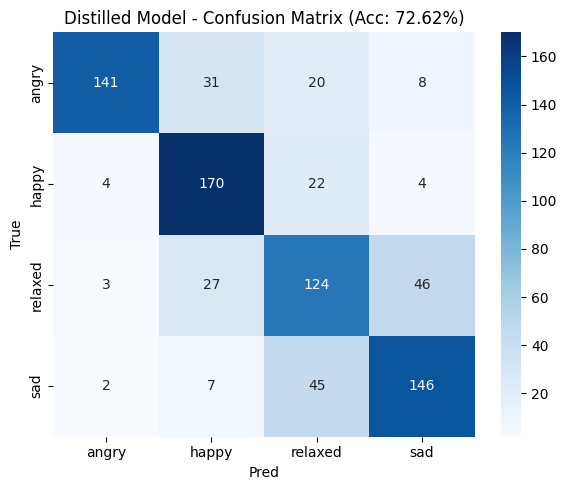

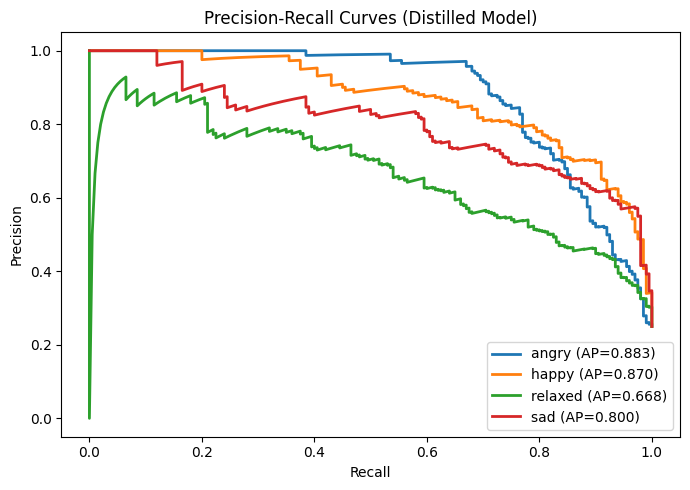


📈 AUC Scores:
        angry: 0.9288
        happy: 0.9476
      relaxed: 0.8591
          sad: 0.9291


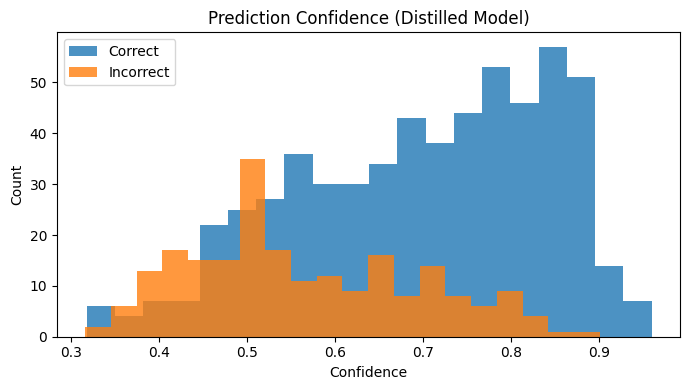


💾 Weights saved: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\distilled_netb3_final_1+0.weights.h5

✅ Training and Evaluation Complete!


In [17]:
print('\n' + '='*60)
print('📊 Evaluating Distilled Model')
print('='*60)

# 🔧 确保使用最佳权重进行评估
if os.path.exists(best_weights_path):
    print(f"📥 Loading best weights from: {best_weights_path}")
    model.load_weights(best_weights_path)
    print("✅ Best weights loaded!")
else:
    print("⚠️ Best weights file not found, using current model weights")

class_names = [k for k, v in sorted(train_gen.class_indices.items(), key=lambda kv: kv[1])]
# 使用自动生成的TAG
eval_results = comprehensive_evaluation(model, val_gen, class_names, out_dir=OUT_DIR, tag=TAG)

# 保存最终模型（仅保存权重与网络结构，避开自定义蒸馏损失序列化问题）
final_model_path = os.path.join(MODEL_DIR, f'distilled_netb3_final_{TAG}.keras')
weights_path = final_model_path.replace('.keras', '.weights.h5')
model.save_weights(weights_path)
print(f"\n💾 Weights saved: {weights_path}")
# Architecture can be rebuilt from doggo_model/dense head code; skip JSON serializing (custom loss causes the failure)

# 保存类别索引
with open(os.path.join(MODEL_DIR, f'class_indices_{TAG}.json'), 'w') as f:
    json.dump(train_gen.class_indices, f, indent=2)

print('\n' + '='*60)
print('✅ Training and Evaluation Complete!')
print('='*60)


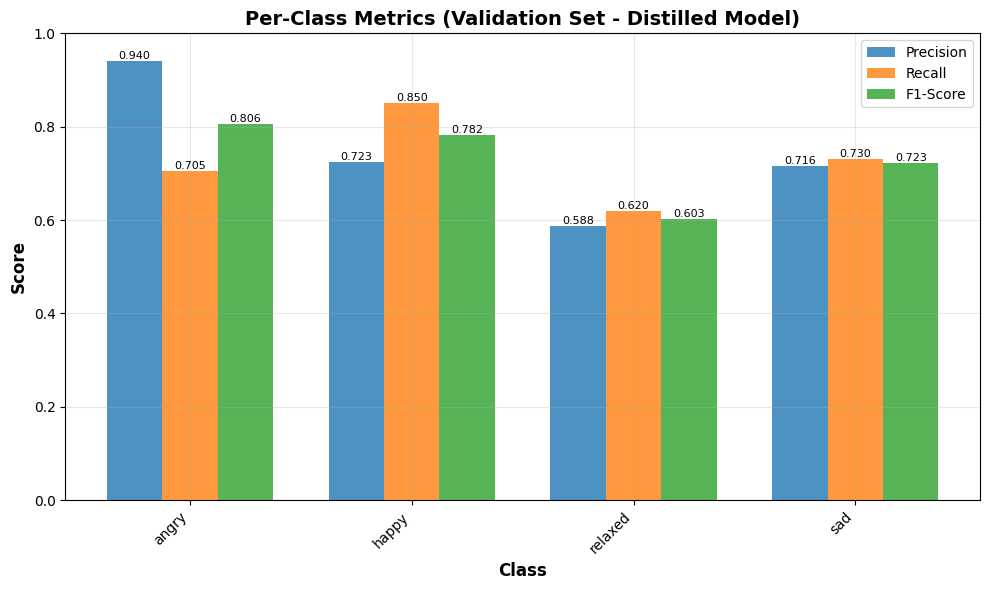


📊 Per-Class Metrics (Validation Set - Distilled Model)
  Class Precision Recall F1-Score  Support
  angry    0.9400 0.7050   0.8057      200
  happy    0.7234 0.8500   0.7816      200
relaxed    0.5877 0.6200   0.6034      200
    sad    0.7157 0.7300   0.7228      200
Weighted Avg Precision: 0.7417
Weighted Avg Recall:    0.7262
Weighted Avg F1-Score:  0.7284

✅ 各类别指标可视化已保存到: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\distilled_metrics_by_class_1+0.png


In [18]:
# 各类别 Precision, Recall 和 F1-Score 可视化
# 使用自动生成的TAG
report_path = os.path.join(OUT_DIR, f'distilled_classification_report_{TAG}.json')

if os.path.exists(report_path):
    with open(report_path, 'r') as f:
        report = json.load(f)
    
    # 提取各类别指标
    class_names = [c for c in report.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]
    precisions = [report[c]['precision'] for c in class_names]
    recalls = [report[c]['recall'] for c in class_names]
    f1_scores = [report[c]['f1-score'] for c in class_names]
    supports = [report[c]['support'] for c in class_names]
    
    # 绘制分组柱状图
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width, precisions, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recalls, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class Metrics (Validation Set - Distilled Model)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.0])
    ax.grid(True, alpha=0.3)
    
    # 在柱子上显示数值
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'distilled_metrics_by_class_{TAG}.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # 打印综合指标表
    print('\n' + '='*70)
    print('📊 Per-Class Metrics (Validation Set - Distilled Model)')
    print('='*70)
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': [f'{p:.4f}' for p in precisions],
        'Recall': [f'{r:.4f}' for r in recalls],
        'F1-Score': [f'{f:.4f}' for f in f1_scores],
        'Support': [int(s) for s in supports]
    })
    print(metrics_df.to_string(index=False))
    print('='*70)
    print(f'Weighted Avg Precision: {report["weighted avg"]["precision"]:.4f}')
    print(f'Weighted Avg Recall:    {report["weighted avg"]["recall"]:.4f}')
    print(f'Weighted Avg F1-Score:  {report["weighted avg"]["f1-score"]:.4f}')
    print('='*70)
    
    print(f'\n✅ 各类别指标可视化已保存到: {os.path.join(OUT_DIR, f"distilled_metrics_by_class_{TAG}.png")}')
else:
    print(f'⚠️  分类报告文件不存在: {report_path}')

## 18. 训练历史可视化

📊 最高验证准确率: 0.7262 (72.62%) @ Epoch 48


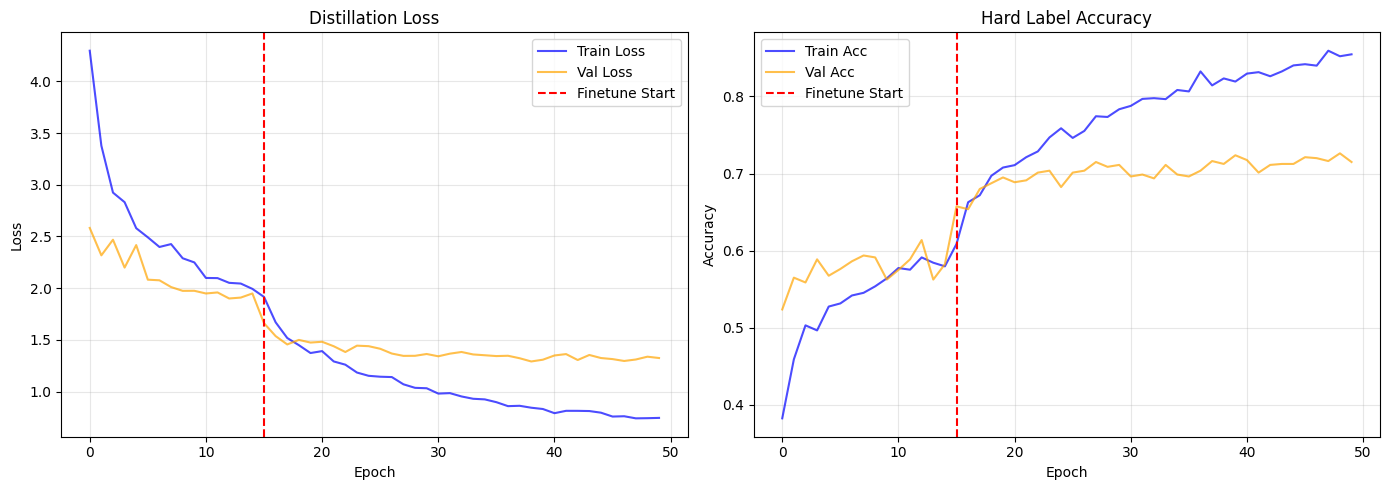


📈 Training curves saved to: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\distillation_training_curves_1+0.png


In [19]:
# Plot training history
# 🔧 修复：正确合并两个history并使用正确的epoch索引
# 使用自动生成的TAG
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 合并两个阶段的历史数据
histories = [initial_history, fine_tune_history]
fine_tune_start_epoch = initial_history.epoch[-1] + 1

def merge_histories(histories):
    """合并多个history对象，返回合并后的字典和对应的epoch列表"""
    merged = {}
    epochs = []
    
    for h in histories:
        h_epochs = h.epoch  # 获取实际的epoch编号列表
        epochs.extend(h_epochs)
        
        for key in h.history.keys():
            if key not in merged:
                merged[key] = []
            merged[key].extend(h.history[key])
    
    return merged, epochs

merged_history, all_epochs = merge_histories(histories)

# Loss
ax = axes[0]
ax.plot(all_epochs, merged_history['loss'], label='Train Loss', alpha=0.7, color='blue')
ax.plot(all_epochs, merged_history['val_loss'], label='Val Loss', alpha=0.7, color='orange')
ax.axvline(x=fine_tune_start_epoch, color='red', linestyle='--', label='Finetune Start')
ax.set_title('Distillation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(alpha=0.3)

# Accuracy
ax = axes[1]
ax.plot(all_epochs, merged_history['hard_acc'], label='Train Acc', alpha=0.7, color='blue')
ax.plot(all_epochs, merged_history['val_hard_acc'], label='Val Acc', alpha=0.7, color='orange')
ax.axvline(x=fine_tune_start_epoch, color='red', linestyle='--', label='Finetune Start')
ax.set_title('Hard Label Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(alpha=0.3)

# 打印最高验证准确率
best_val_acc = max(merged_history['val_hard_acc'])
best_epoch = all_epochs[merged_history['val_hard_acc'].index(best_val_acc)]
print(f"📊 最高验证准确率: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) @ Epoch {best_epoch}")

plt.tight_layout()
# 使用自动生成的TAG
plt.savefig(os.path.join(OUT_DIR, f'distillation_training_curves_{TAG}.png'), dpi=150)
plt.show()

print(f"\n📈 Training curves saved to: {os.path.join(OUT_DIR, f'distillation_training_curves_{TAG}.png')}")

## 19. 总结

### ✅ 完成的工作
1. 使用 gpt5_mini 的软标签作为教师知识（教师准确率83%）
2. 训练EfficientNetB3学生模型（特征提取12轮 + 微调28轮，总40轮）
3. 损失函数：α=0.5 (KL) + β=0.5 (CE) 🎯 平衡软标签与硬标签蒸馏
4. 训练配置与baseline完全一致：batch_size=32, lr=1e-4/3e-5, 轻度数据增强 ✨
5. Temperature=3.0 提高软标签平滑程度以便学生学习类间相似性，解冻70层 🔧
6. 完整评估（准确率、混淆矩阵、PR曲线、AUC等）

### 📊 关键指标
查看上方的评估结果

### 🎯 v10优化目标
- **目标**: 超越baseline 80%，接近教师模型83%
- **策略**: Temperature=3.0 + α=0.5/β=0.5 平衡软硬标签蒸馏

### 🔄 下一步
- 与baseline（无蒸馏）模型对比性能
- 在新测试集（7460张）上评估泛化能力
- 与 ResNet50 蒸馏版本对比性能差异


In [20]:
# Summary: saved artifacts quick-check and eval summary
import glob
import os
import json
import numpy as _np
print(f'\n🔎 Checking saved artifacts for TAG="{TAG}"...')
# Ensure PROJECT_ROOT, MODEL_DIR, OUT_DIR are available when running this cell standalone
if 'PROJECT_ROOT' not in globals():
    PROJECT_ROOT = os.path.abspath('..')
if 'MODEL_DIR' not in globals():
    MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')
if 'OUT_DIR' not in globals():
    OUT_DIR = os.path.join(PROJECT_ROOT, 'results')
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Safe glob (in case variables are None or invalid)
# 使用TAG变量进行搜索
try:
    models_found = glob.glob(os.path.join(MODEL_DIR, f'*{TAG}*'))
except Exception as e:
    print('Could not list models:', e)
    models_found = []
try:
    outs_found = glob.glob(os.path.join(OUT_DIR, f'*{TAG}*'))
except Exception as e:
    print('Could not list outputs:', e)
    outs_found = []

print(f"\nModels ({len(models_found)}):")
for p in models_found:
    print('  -', p)
print(f"\nOutputs ({len(outs_found)}):")
for p in outs_found:
    print('  -', p)

# Report basic eval_results if available
if 'eval_results' in globals():
    try:
        print('\n📊 eval_results summary:')
        print('  Accuracy:', eval_results.get('accuracy'))
        if isinstance(eval_results.get('report'), dict):
            # print a trimmed classification report summary
            rep = eval_results['report']
            for k,v in rep.items():
                if isinstance(v, dict) and 'f1-score' in v:
                    print(f"   - {k}: f1={v.get('f1-score'):.3f}, precision={v.get('precision'):.3f}, recall={v.get('recall'):.3f}")
    except Exception as e:
        print('Could not pretty-print eval_results:', e)
else:
    print('\n⚠️ No `eval_results` variable found. Run the evaluation cell to populate it.')

print('\n✅ Summary check complete. You can open the listed files or rerun evaluation.')


🔎 Checking saved artifacts for TAG="1+0"...

Models (11):
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\class_indices_0.01+0.99.json
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\class_indices_0.1+0.9.json
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\class_indices_1+0.json
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\distilled_netb3_0.01+0.99.keras
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\distilled_netb3_0.1+0.9.keras
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\distilled_netb3_1+0.keras
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\distilled_netb3_final_0.01+0.99.keras
  - e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\

## ⚠️ 重要提示：TAG使用说明

**所有输出文件现在自动使用TAG变量！**

- `TAG` 在配置部分自动生成，格式为 `"{alpha}+{beta}"`
- 修改 `CONFIG['distillation']['alpha']` 和 `CONFIG['distillation']['beta']` 后，TAG会自动更新
- 所有文件名、路径等都应该使用 `TAG` 变量而不是硬编码的 `'1+0'`

**如果下面的单元格中还有硬编码的tag（如 `tag = '1+0'`），请将它们改为直接使用 `TAG`**

✅ 找到新测试数据集: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\..\LLM-Emotion（EfficientNetB3only）\data\new_test_dataset
✅ 已加载模型权重: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\best_distilled_efnb3_weights.h5
✅ 已加载类别索引: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\models\class_indices_1+0.json
📋 训练时的类别顺序: ['angry', 'happy', 'relaxed', 'sad']
Found 4000 images belonging to 4 classes.

📊 新数据集信息:
   总样本数: 4000
   类别顺序: ['angry', 'happy', 'relaxed', 'sad']
   类别索引: {'angry': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}

🔮 开始预测...
500/500 [==============================] - 20s 37ms/step

🎯 新数据集测试结果
准确率: 0.7013 (70.12%)
正确: 2805 / 4000
错误: 1195 / 4000

分类报告:
              precision   recall  f1-score     support
angry          0.868000  0.65100  0.744000  1000.00000
happy          0.698113  0.88800  0.781690  1000.00000
relaxed        0.583414  0.60500  0.594011  1000.00000
sad            0.

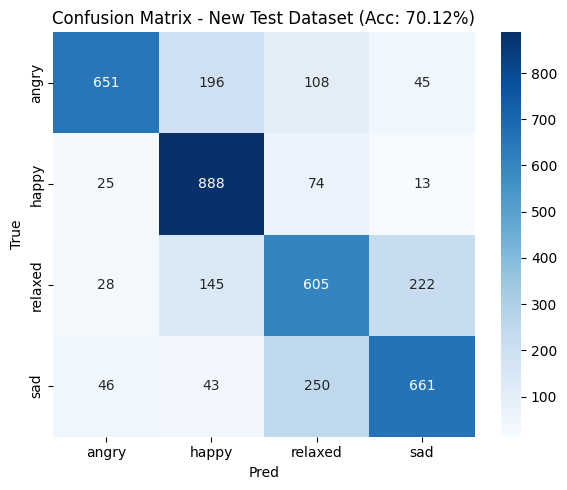


主要混淆情况:
  angry    → happy   :  196 次  (19.6%)
  angry    → relaxed :  108 次  (10.8%)
  relaxed  → happy   :  145 次  (14.5%)
  relaxed  → sad     :  222 次  (22.2%)
  sad      → relaxed :  250 次  (25.0%)

✅ 混淆矩阵已保存: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\confusion_matrix_new_dataset_1+0.png
✅ 测试报告已保存: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\reports


In [21]:
# 🧪 新数据集泛化能力测试

# 定义混淆矩阵绘图函数
def plot_cm(cm, class_names, title='Confusion Matrix', save_path=None):
    """绘制混淆矩阵"""
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.tight_layout()
    if save_path: 
        plt.savefig(save_path, dpi=150)
    plt.show()

# 检查新数据集是否存在
NEW_TEST_DIR = os.path.join(PROJECT_ROOT, '..', 'LLM-Emotion（EfficientNetB3only）', 'data', 'new_test_dataset')

if not os.path.exists(NEW_TEST_DIR):
    print('⚠️  新测试数据集未找到，跳过泛化测试')
    print(f'   预期路径: {NEW_TEST_DIR}')
    print('   如需测试，请将数据集放置到上述路径')
else:
    print(f'✅ 找到新测试数据集: {NEW_TEST_DIR}')
    
    # 加载最佳模型权重（尝试多个可能的文件名）
    # 使用自动生成的TAG
    possible_weights = [
        os.path.join(MODEL_DIR, 'best_distilled_efnb3_weights.h5'),
        os.path.join(MODEL_DIR, f'best_distilled_efnb3_weights_{TAG}.h5')
    ]
    
    best_weights_path = None
    for path in possible_weights:
        if os.path.exists(path):
            best_weights_path = path
            break
    
    if best_weights_path is None:
        print(f'⚠️  模型权重未找到，尝试的路径:')
        for path in possible_weights:
            print(f'   - {path}')
        print('   将使用当前模型状态进行测试')
    else:
        # 加载权重到当前模型
        model.load_weights(best_weights_path)
        print(f'✅ 已加载模型权重: {best_weights_path}')
    
    # 加载训练时的类别索引
    possible_class_indices = [
        os.path.join(MODEL_DIR, f'class_indices_{TAG}.json'),
        os.path.join(MODEL_DIR, 'class_indices_0.5+0.5.json')
    ]
    
    train_class_names = None
    for path in possible_class_indices:
        if os.path.exists(path):
            with open(path, 'r') as f:
                train_indices = json.load(f)
            train_class_names = [k for k, v in sorted(train_indices.items(), key=lambda kv: kv[1])]
            print(f'✅ 已加载类别索引: {path}')
            break
    
    if train_class_names is None:
        # 使用当前 train_gen 的类别索引
        train_class_names = [k for k, v in sorted(train_gen.class_indices.items(), key=lambda kv: kv[1])]
        train_indices = train_gen.class_indices
        print(f'ℹ️  使用train_gen的类别索引')
    
    print(f'📋 训练时的类别顺序: {train_class_names}')
    
    # 创建测试数据生成器（不做数据增强）
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_gen = test_datagen.flow_from_directory(
        NEW_TEST_DIR,
        target_size=CONFIG['image_size'],  # 使用与训练时相同的尺寸 (300, 300)
        batch_size=CONFIG['batch_size'],
        class_mode='categorical',
        shuffle=False,
        classes=train_class_names  # 🔧 使用训练时的类别顺序
    )
    
    print(f'\n📊 新数据集信息:')
    print(f'   总样本数: {test_gen.n}')
    print(f'   类别顺序: {list(test_gen.class_indices.keys())}')
    print(f'   类别索引: {test_gen.class_indices}')
    
    # 生成预测
    print('\n🔮 开始预测...')
    predictions = model.predict(test_gen, verbose=1)
    y_pred_new = np.argmax(predictions, axis=1)
    y_true_new = test_gen.classes
    
    # 计算准确率
    accuracy_new = (y_pred_new == y_true_new).mean()
    
    print('\n' + '='*60)
    print('🎯 新数据集测试结果')
    print('='*60)
    print(f'准确率: {accuracy_new:.4f} ({accuracy_new*100:.2f}%)')
    print(f'正确: {(y_pred_new == y_true_new).sum()} / {len(y_pred_new)}')
    print(f'错误: {(y_pred_new != y_true_new).sum()} / {len(y_pred_new)}')
    
    # 分类报告
    print('\n分类报告:')
    report_new = classification_report(y_true_new, y_pred_new, target_names=train_class_names, output_dict=True)
    print(pd.DataFrame(report_new).T)
    
    # AUC
    print('\n各类别 AUC:')
    for i, cname in enumerate(train_class_names):
        y_true_bin = (y_true_new == i).astype(int)
        auc = roc_auc_score(y_true_bin, predictions[:, i])
        print(f'  {cname:10s}: {auc:.4f}')
    
    # 性能对比
    print('\n' + '='*60)
    print('📊 性能对比')
    print('='*60)
    if 'eval_results' in globals() and 'accuracy' in eval_results:
        val_acc = eval_results['accuracy']
        print(f'原始验证集 (800张):     {val_acc*100:.2f}%')
        print(f'新测试集 ({test_gen.n}张): {accuracy_new*100:.2f}%')
        diff = (accuracy_new - val_acc) * 100
        print(f'性能差异:                {diff:+.2f}%')
        
        if abs(diff) < 5:
            print('\n✅ 泛化能力良好！')
        elif diff < -5:
            print('\n⚠️  新数据集性能下降明显')
        else:
            print('\n🤔 新数据集性能提升')
    print('='*60)
    
    # 保存报告
    with open(os.path.join(REPORT_DIR, f'classification_report_new_dataset_{TAG}.json'), 'w') as f:
        json.dump(report_new, f, indent=2)
    
    # 混淆矩阵
    cm_new = confusion_matrix(y_true_new, y_pred_new)
    plot_cm(cm_new, train_class_names, 
            title=f'Confusion Matrix - New Test Dataset (Acc: {accuracy_new*100:.2f}%)',
            save_path=os.path.join(OUT_DIR, f'confusion_matrix_new_dataset_{TAG}.png'))
    
    # 分析混淆
    print('\n主要混淆情况:')
    for i in range(len(train_class_names)):
        for j in range(len(train_class_names)):
            if i != j and cm_new[i, j] > 100:
                print(f'  {train_class_names[i]:8s} → {train_class_names[j]:8s}: {cm_new[i, j]:4d} 次 ',
                      f'({cm_new[i, j]/cm_new[i].sum()*100:.1f}%)')
    
    # 保存预测概率
    np.save(os.path.join(OUT_DIR, f'new_dataset_probs_{TAG}.npy'), predictions)
    
    print(f'\n✅ 混淆矩阵已保存: {os.path.join(OUT_DIR, f"confusion_matrix_new_dataset_{TAG}.png")}')
    print(f'✅ 测试报告已保存: {REPORT_DIR}')

## 20. 新数据集详细可视化分析

包括置信度分布、各类别准确率对比、错误预测分析、置信度vs准确率关系等。

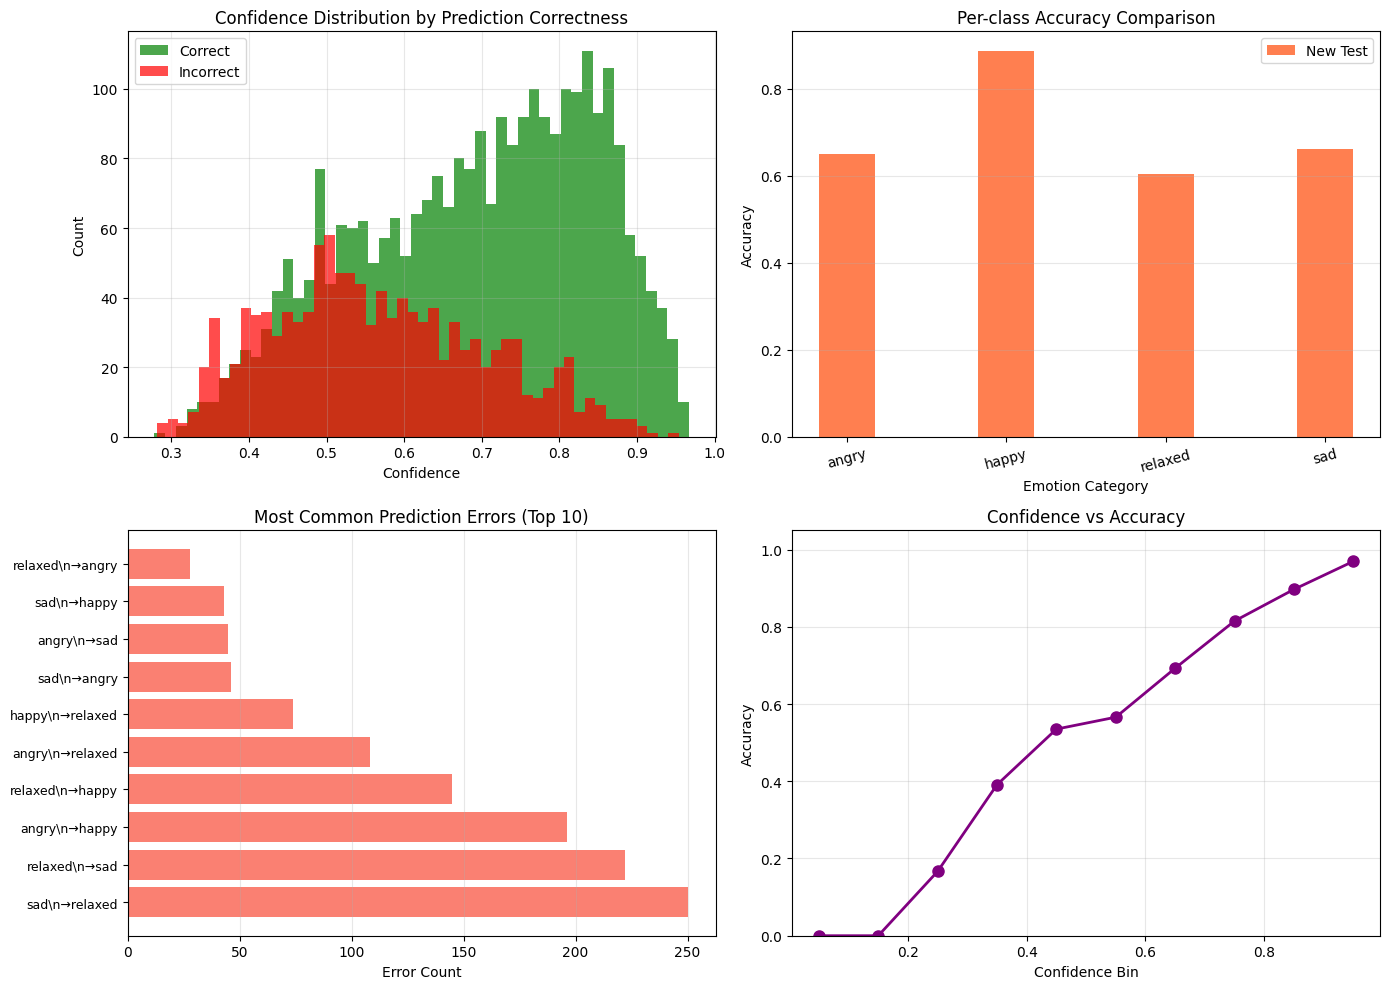


📊 Detailed analysis saved to: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\new_dataset_detailed_analysis_1+0.png


In [22]:
# 详细可视化分析（新数据集）
if 'predictions' in globals() and 'y_true_new' in globals():
    import numpy as _np
    
    # 使用正确的变量名
    y_true_mapped = y_true_new
    y_pred_mapped = y_pred_new
    probs_mapped = predictions
    
    # 计算每个类别的准确率
    per_class_acc_new = []
    for i in range(len(train_class_names)):
        mask = y_true_mapped == i
        if mask.sum() > 0:
            acc = (y_pred_mapped[mask] == y_true_mapped[mask]).mean()
        else:
            acc = 0
        per_class_acc_new.append(acc)
    
    # 计算置信度统计
    conf_new = probs_mapped.max(axis=1)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 置信度分布直方图
    ax = axes[0, 0]
    ax.hist(conf_new[y_pred_mapped == y_true_mapped], bins=50, alpha=0.7, label='Correct', color='green')
    ax.hist(conf_new[y_pred_mapped != y_true_mapped], bins=50, alpha=0.7, label='Incorrect', color='red')
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Count')
    ax.set_title('Confidence Distribution by Prediction Correctness')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 2. 各类别准确率对比（与验证集对比）
    ax = axes[0, 1]
    x = _np.arange(len(train_class_names))
    width = 0.35
    
    # 如果有验证集的 per_class_acc，进行对比
    if 'eval_results' in globals() and 'per_class_accuracy' in eval_results:
        val_acc_per_class = [eval_results['per_class_accuracy'].get(c, 0) for c in train_class_names]
        ax.bar(x - width/2, val_acc_per_class, width, label='Validation', color='steelblue')
    
    new_acc_per_class = per_class_acc_new
    ax.bar(x + width/2 if 'eval_results' in globals() and 'per_class_accuracy' in eval_results else x, 
           new_acc_per_class, width, label='New Test', color='coral')
    ax.set_xlabel('Emotion Category')
    ax.set_ylabel('Accuracy')
    ax.set_title('Per-class Accuracy Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(train_class_names, rotation=15)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 3. 错误预测分析（Top 10最常见错误）
    ax = axes[1, 0]
    error_pairs = []
    for true_idx in range(len(train_class_names)):
        for pred_idx in range(len(train_class_names)):
            if true_idx != pred_idx:
                count = ((y_true_mapped == true_idx) & (y_pred_mapped == pred_idx)).sum()
                if count > 0:
                    error_pairs.append((f'{train_class_names[true_idx]}\\n→{train_class_names[pred_idx]}', count))
    error_pairs.sort(key=lambda x: x[1], reverse=True)
    if error_pairs:
        labels, counts = zip(*error_pairs[:10])  # 前10个最常见错误
        ax.barh(range(len(labels)), counts, color='salmon')
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_xlabel('Error Count')
        ax.set_title('Most Common Prediction Errors (Top 10)')
        ax.grid(axis='x', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No prediction errors', ha='center', va='center')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    
    # 4. 置信度 vs 准确率关系
    ax = axes[1, 1]
    conf_bins = _np.linspace(0, 1, 11)
    bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
    accuracies_by_conf = []
    counts_by_conf = []
    for i in range(len(conf_bins) - 1):
        mask = (conf_new >= conf_bins[i]) & (conf_new < conf_bins[i+1])
        if mask.sum() > 0:
            accuracies_by_conf.append((y_pred_mapped[mask] == y_true_mapped[mask]).mean())
            counts_by_conf.append(mask.sum())
        else:
            accuracies_by_conf.append(0)
            counts_by_conf.append(0)
    
    ax.plot(bin_centers, accuracies_by_conf, marker='o', linewidth=2, markersize=8, color='purple')
    ax.set_xlabel('Confidence Bin')
    ax.set_ylabel('Accuracy')
    ax.set_title('Confidence vs Accuracy')
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'new_dataset_detailed_analysis_{TAG}.png'), dpi=150)
    plt.show()
    
    print(f'\n📊 Detailed analysis saved to: {os.path.join(OUT_DIR, f"new_dataset_detailed_analysis_{TAG}.png")}')
else:
    print('⚠️  新数据集预测结果不存在，请先运行新数据集测试部分（Cell 41）')

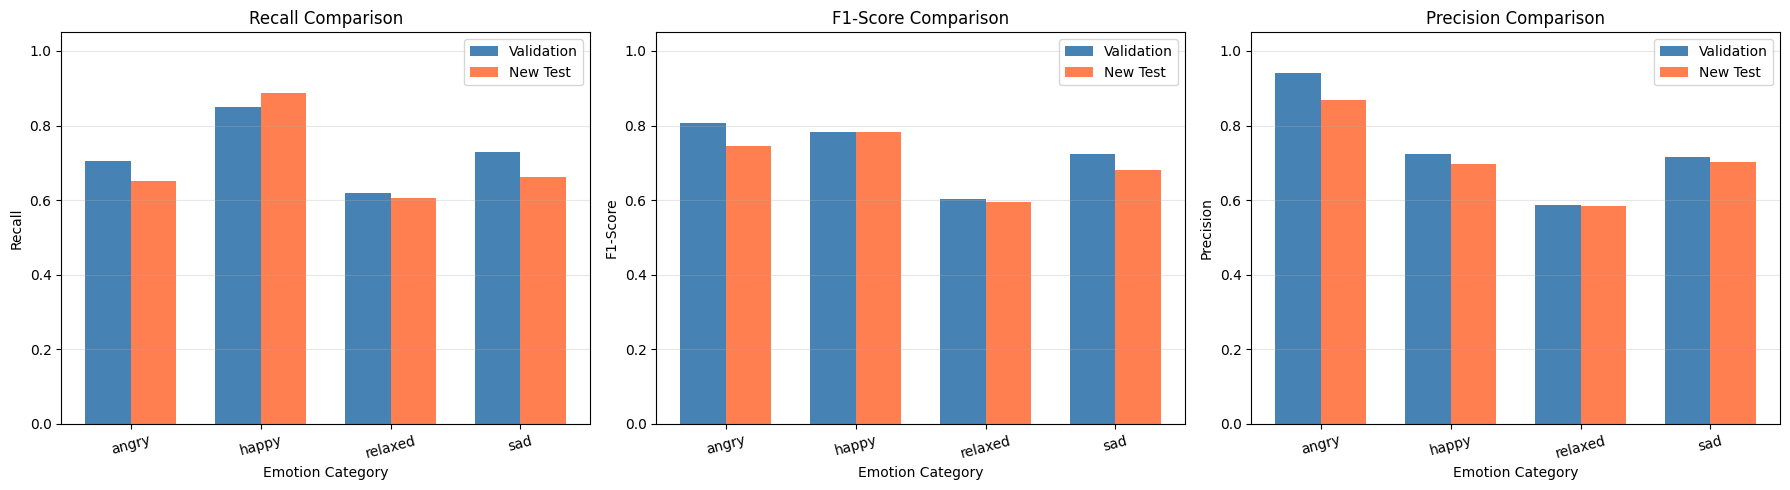


📈 Comparison chart saved to: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\recall_f1_precision_comparison_1+0.png

📊 Detailed Metric Comparison:
Category     Val Recall New Recall Val F1     New F1     Val Prec   New Prec  
angry             0.705      0.651      0.806      0.744      0.940      0.868
happy             0.850      0.888      0.782      0.782      0.723      0.698
relaxed           0.620      0.605      0.603      0.594      0.588      0.583
sad               0.730      0.661      0.723      0.681      0.716      0.702

💾 Comparison data saved to: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\reports\generalization_comparison_1+0.json


In [23]:
# 新数据集 Recall 和 F1-Score 详细对比
if 'predictions' in globals() and 'y_true_new' in globals():
    # 使用正确的变量名
    y_true_mapped = y_true_new
    y_pred_mapped = y_pred_new
    
    # 计算新数据集的分类报告
    report_new = classification_report(y_true_mapped, y_pred_mapped, 
                                       target_names=train_class_names, 
                                       output_dict=True)
    
    # 从两个报告中提取指标
    report_val_path = os.path.join(OUT_DIR, f'distilled_classification_report_{TAG}.json')
    if os.path.exists(report_val_path):
        with open(report_val_path, 'r') as f:
            report_val = json.load(f)
        
        # 提取每类的 Recall, F1, Precision
        recalls_val = [report_val.get(c, {}).get('recall', 0) for c in train_class_names]
        f1_scores_val = [report_val.get(c, {}).get('f1-score', 0) for c in train_class_names]
        precisions_val = [report_val.get(c, {}).get('precision', 0) for c in train_class_names]
        
        recalls_new = [report_new.get(c, {}).get('recall', 0) for c in train_class_names]
        f1_scores_new = [report_new.get(c, {}).get('f1-score', 0) for c in train_class_names]
        precisions_new = [report_new.get(c, {}).get('precision', 0) for c in train_class_names]
        
        # 绘图：Recall 和 F1-Score 对比
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        x = _np.arange(len(train_class_names))
        width = 0.35
        
        # Recall 对比
        ax = axes[0]
        bars1 = ax.bar(x - width/2, recalls_val, width, label='Validation', color='steelblue')
        bars2 = ax.bar(x + width/2, recalls_new, width, label='New Test', color='coral')
        ax.set_xlabel('Emotion Category')
        ax.set_ylabel('Recall')
        ax.set_title('Recall Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(train_class_names, rotation=15)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        # F1-Score 对比
        ax = axes[1]
        bars1 = ax.bar(x - width/2, f1_scores_val, width, label='Validation', color='steelblue')
        bars2 = ax.bar(x + width/2, f1_scores_new, width, label='New Test', color='coral')
        ax.set_xlabel('Emotion Category')
        ax.set_ylabel('F1-Score')
        ax.set_title('F1-Score Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(train_class_names, rotation=15)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        # Precision 对比
        ax = axes[2]
        bars1 = ax.bar(x - width/2, precisions_val, width, label='Validation', color='steelblue')
        bars2 = ax.bar(x + width/2, precisions_new, width, label='New Test', color='coral')
        ax.set_xlabel('Emotion Category')
        ax.set_ylabel('Precision')
        ax.set_title('Precision Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(train_class_names, rotation=15)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f'recall_f1_precision_comparison_{TAG}.png'), dpi=150)
        plt.show()
        
        print(f'\n📈 Comparison chart saved to: {os.path.join(OUT_DIR, f"recall_f1_precision_comparison_{TAG}.png")}')
        
        # 打印详细对比
        print('\n📊 Detailed Metric Comparison:')
        print('='*80)
        print(f'{"Category":12s} {"Val Recall":10s} {"New Recall":10s} {"Val F1":10s} {"New F1":10s} {"Val Prec":10s} {"New Prec":10s}')
        print('='*80)
        for i, cname in enumerate(train_class_names):
            print(f'{cname:12s} {recalls_val[i]:10.3f} {recalls_new[i]:10.3f} '
                  f'{f1_scores_val[i]:10.3f} {f1_scores_new[i]:10.3f} '
                  f'{precisions_val[i]:10.3f} {precisions_new[i]:10.3f}')
        print('='*80)
        
        # 保存对比JSON
        comparison_data = {
            'validation': {c: {'recall': r, 'f1': f, 'precision': p} 
                          for c, r, f, p in zip(train_class_names, recalls_val, f1_scores_val, precisions_val)},
            'new_test': {c: {'recall': r, 'f1': f, 'precision': p} 
                        for c, r, f, p in zip(train_class_names, recalls_new, f1_scores_new, precisions_new)}
        }
        with open(os.path.join(REPORT_DIR, f'generalization_comparison_{TAG}.json'), 'w') as f:
            json.dump(comparison_data, f, indent=2)
        print(f'\n💾 Comparison data saved to: {os.path.join(REPORT_DIR, f"generalization_comparison_{TAG}.json")}')
    else:
        print(f'⚠️  验证集分类报告不存在: {report_val_path}，无法进行对比')
else:
    print('⚠️  新数据集预测结果不存在，请先运行新数据集测试部分（Cell 41）')

## 21. PR曲线和ROC曲线（新数据集）

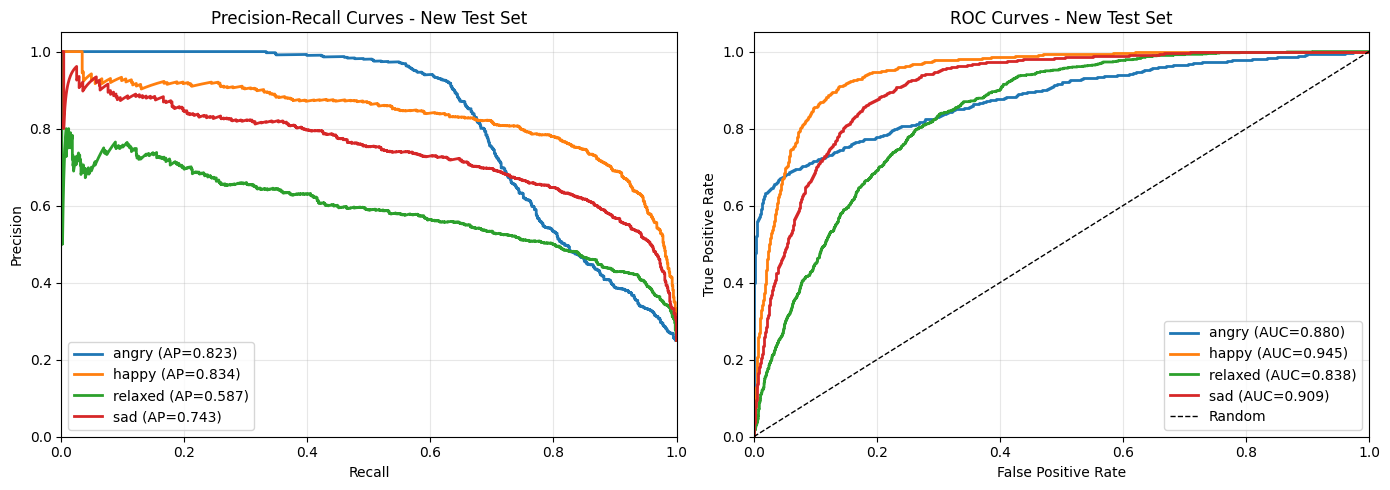


📈 PR/ROC curves saved to: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\pr_roc_curves_new_dataset_1+0.png


In [24]:
# 绘制PR曲线和ROC曲线（新数据集）
if 'predictions' in globals() and 'y_true_new' in globals():
    from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
    
    # 使用正确的变量名
    y_true_mapped = y_true_new
    y_pred_mapped = y_pred_new
    probs_mapped = predictions
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. PR曲线
    ax = axes[0]
    for i, cname in enumerate(train_class_names):
        y_true_bin = (y_true_mapped == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_bin, probs_mapped[:, i])
        ap = average_precision_score(y_true_bin, probs_mapped[:, i])
        ax.plot(recall, precision, label=f'{cname} (AP={ap:.3f})', linewidth=2)
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves - New Test Set')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    # 2. ROC曲线
    ax = axes[1]
    for i, cname in enumerate(train_class_names):
        y_true_bin = (y_true_mapped == i).astype(int)
        fpr, tpr, _ = roc_curve(y_true_bin, probs_mapped[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{cname} (AUC={roc_auc:.3f})', linewidth=2)
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves - New Test Set')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'pr_roc_curves_new_dataset_{TAG}.png'), dpi=150)
    plt.show()
    
    print(f'\n📈 PR/ROC curves saved to: {os.path.join(OUT_DIR, f"pr_roc_curves_new_dataset_{TAG}.png")}')
else:
    print('⚠️  新数据集预测结果不存在，请先运行新数据集测试部分（Cell 41）')

## 22. 最终总结

所有测试和可视化已完成！

In [25]:
# 最终总结和文件清单
if 'predictions' in globals():
    print('\n' + '='*70)
    print('📋 New Dataset Generalization Test - Full Report')
    print('='*70)
    
    print('\n✅ Generated files:')
    print('\n📊 Report files:')
    report_files = [
        f'classification_report_new_dataset_{TAG}.json',
        f'generalization_comparison_{TAG}.json'
    ]
    for fname in report_files:
        fpath = os.path.join(REPORT_DIR, fname)
        if os.path.exists(fpath):
            print(f'  ✓ {fpath}')
    
    print('\n📈 Visualization files:')
    viz_files = [
        f'confusion_matrix_new_dataset_{TAG}.png',
        f'new_dataset_detailed_analysis_{TAG}.png',
        f'pr_roc_curves_new_dataset_{TAG}.png'
    ]
    for fname in viz_files:
        fpath = os.path.join(OUT_DIR, fname)
        if os.path.exists(fpath):
            print(f'  ✓ {fpath}')
    
    print('\n💾 Data files:')
    data_files = [f'new_dataset_probs_{TAG}.npy']
    for fname in data_files:
        fpath = os.path.join(OUT_DIR, fname)
        if os.path.exists(fpath):
            print(f'  ✓ {fpath}')
    
    print('\n' + '='*70)
    print('📈 Key Metrics Summary:')
    print('='*70)
    print(f'New test set samples: {test_gen.n}')
    print(f'Overall accuracy: {accuracy_new:.4f} ({accuracy_new*100:.2f}%)')
    
    if 'eval_results' in globals() and 'accuracy' in eval_results:
        val_acc = eval_results['accuracy']
        diff = (accuracy_new - val_acc) * 100
        print(f'Original validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)')
        print(f'Performance diff: {diff:+.2f}%')
    
    print('\nPer-class performance:')
    for i, cname in enumerate(train_class_names):
        if cname in report_new:
            f1 = report_new[cname]['f1-score']
            precision = report_new[cname]['precision']
            recall = report_new[cname]['recall']
            print(f'  {cname:10s}: F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}')
    
    print('\n' + '='*70)
    print('🎉 New dataset generalization test completed!')
    print('='*70)
else:
    print('⚠️  Please run the generalization test cell first to generate predictions.')


📋 New Dataset Generalization Test - Full Report

✅ Generated files:

📊 Report files:
  ✓ e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\reports\classification_report_new_dataset_1+0.json
  ✓ e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\reports\generalization_comparison_1+0.json

📈 Visualization files:
  ✓ e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\confusion_matrix_new_dataset_1+0.png
  ✓ e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\new_dataset_detailed_analysis_1+0.png
  ✓ e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\pr_roc_curves_new_dataset_1+0.png

💾 Data files:
  ✓ e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\results\new_dataset_probs_1+0.npy

📈 Key Metrics Summary:
New test set samples: 4000
Overall accuracy: 0.7013 (70.12%)
Original validation

In [26]:
# 导出每张图片的预测结果到CSV
if 'predictions' in globals() and 'y_pred_new' in globals():
    # 使用正确的变量名
    y_true_mapped = y_true_new
    y_pred_mapped = y_pred_new
    probs_mapped = predictions
    
    # 获取所有文件路径
    filenames = test_gen.filenames
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        'filename': filenames,
        'true_label_idx': y_true_mapped,
        'pred_label_idx': y_pred_mapped,
        'true_label': [train_class_names[i] for i in y_true_mapped],
        'pred_label': [train_class_names[i] for i in y_pred_mapped],
        'is_correct': (y_pred_mapped == y_true_mapped).astype(int),
        'confidence': probs_mapped.max(axis=1),
        'prob_angry': probs_mapped[:, train_gen.class_indices['angry']],
        'prob_happy': probs_mapped[:, train_gen.class_indices['happy']],
        'prob_relaxed': probs_mapped[:, train_gen.class_indices['relaxed']],
        'prob_sad': probs_mapped[:, train_gen.class_indices['sad']]
    })
    
    # 保存CSV
    csv_path = os.path.join(REPORT_DIR, f'new_dataset_predictions_{TAG}.csv')
    results_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    
    print(f'✅ 预测结果已保存到: {csv_path}')
    print(f'   总样本数: {len(results_df)}')
    print(f'   正确预测: {results_df["is_correct"].sum()} ({results_df["is_correct"].mean()*100:.2f}%)')
    print(f'   错误预测: {(~results_df["is_correct"].astype(bool)).sum()}')
    
    # 显示前10行
    print('\n📋 预测结果示例 (前10行):')
    display(results_df.head(10))
    
    # 显示错误预测示例
    errors_df = results_df[results_df['is_correct'] == 0]
    print(f'\n❌ 错误预测示例 (共{len(errors_df)}个，显示前10个):')
    display(errors_df.head(10))
else:
    print('⚠️ 请先运行泛化测试单元格（Cell 41）生成预测结果。')

✅ 预测结果已保存到: e:\BaiduNetdiskDownload\LLMemotion\LLMemotion\LLMemotion\（1.1）EfficientNETB3+GPT\reports\new_dataset_predictions_1+0.csv
   总样本数: 4000
   正确预测: 2805 (70.12%)
   错误预测: 1195

📋 预测结果示例 (前10行):


,filename,true_label_idx,pred_label_idx,true_label,pred_label,is_correct,confidence,prob_angry,prob_happy,prob_relaxed,prob_sad
0,angry\09dUVMcjCDfOtbeYDQg5Fvu3GPHWJg811.jpg,0,1,angry,happy,0,0.698397,0.030499,0.698397,0.206703,0.064400
1,angry\0AvKtuzA7LfxnKaO0bey9mQMLnxXad73.jpg,0,0,angry,angry,1,0.959885,0.959885,0.017233,0.010242,0.012640
2,angry\0C5yo7GxMy8lztxNZvSdfEx2gSPRTR701.jpg,0,0,angry,angry,1,0.868379,0.868379,0.033831,0.051877,0.045913
3,angry\0C9jEgFQHsh36W5U2u5CA98lB7C5eX806.jpg,0,2,angry,relaxed,0,0.761885,0.024611,0.097090,0.761885,0.116414
4,angry\0RXraPIKC00Dz1qkuMbj8XbuR80g5Z893.jpg,0,1,angry,happy,0,0.431856,0.060232,0.431856,0.372340,0.135572
5,angry\0TSpHUDh1xIQthYrtH8E1UZQ72rcTZ68.jpg,0,0,angry,angry,1,0.835728,0.835728,0.032959,0.083228,0.048084
6,angry\0aNyXBrmNA7XdefwHvgO2n1rnpqQAp885.jpg,0,1,angry,happy,0,0.846862,0.017599,0.846862,0.112305,0.023234
7,angry\0dWl0dRT9Pc98fjFSvGOXlGlE0B4E6267.jpg,0,1,angry,happy,0,0.644770,0.033586,0.644770,0.226236,0.095408
8,angry\0da4j6Ehkb6Ml0YBRiWmsBU2wEMoXP409.jpg,0,0,angry,angry,1,0.881372,0.881372,0.044458,0.035051,0.039119
9,angry\0jgI6KwR6IGvq9CAMBB3srLRa0W7z7192.jpg,0,1,angry,happy,0,0.546720,0.360189,0.546720,0.066232,0.026859



❌ 错误预测示例 (共1195个，显示前10个):


,filename,true_label_idx,pred_label_idx,true_label,pred_label,is_correct,confidence,prob_angry,prob_happy,prob_relaxed,prob_sad
0,angry\09dUVMcjCDfOtbeYDQg5Fvu3GPHWJg811.jpg,0,1,angry,happy,0,0.698397,0.030499,0.698397,0.206703,0.064400
3,angry\0C9jEgFQHsh36W5U2u5CA98lB7C5eX806.jpg,0,2,angry,relaxed,0,0.761885,0.024611,0.097090,0.761885,0.116414
4,angry\0RXraPIKC00Dz1qkuMbj8XbuR80g5Z893.jpg,0,1,angry,happy,0,0.431856,0.060232,0.431856,0.372340,0.135572
6,angry\0aNyXBrmNA7XdefwHvgO2n1rnpqQAp885.jpg,0,1,angry,happy,0,0.846862,0.017599,0.846862,0.112305,0.023234
7,angry\0dWl0dRT9Pc98fjFSvGOXlGlE0B4E6267.jpg,0,1,angry,happy,0,0.644770,0.033586,0.644770,0.226236,0.095408
9,angry\0jgI6KwR6IGvq9CAMBB3srLRa0W7z7192.jpg,0,1,angry,happy,0,0.546720,0.360189,0.546720,0.066232,0.026859
10,angry\0nhvFJW7Q5S48PygRMOimUipiYweig911.jpg,0,1,angry,happy,0,0.812088,0.032912,0.812088,0.133824,0.021177
11,angry\0qqRaCQQtAQj2PGIRQrNJa1rnnx36W620.jpg,0,1,angry,happy,0,0.809383,0.000345,0.809383,0.184943,0.005329
14,angry\0tVivKVWy9s7Zp3vR7LN1syiMBfAoR375.jpg,0,2,angry,relaxed,0,0.800859,0.009143,0.077328,0.800859,0.112670
15,angry\0vltcJWTxKRV0vXzb1Ij2qqDNSheoD824.jpg,0,2,angry,relaxed,0,0.628656,0.233558,0.073437,0.628656,0.064349
